In [ ]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from skimage.color import gray2rgb
from sklearn.utils import shuffle
import warnings
import torch
from torchvision import models, transforms
from torch import nn
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report

warnings.filterwarnings('ignore')

In [ ]:
# Let's load the train, validation and test arrays
X_train = np.load('/content/drive/MyDrive/Numpy_ADNI/AmyPET_train_images.npy', allow_pickle=True)
X_val = np.load('/content/drive/MyDrive/Numpy_ADNI/AmyPET_val_images.npy', allow_pickle=True)
X_test = np.load('/content/drive/MyDrive/Numpy_ADNI/AmyPET_test_images.npy', allow_pickle=True)
Y_train = np.load('/content/drive/MyDrive/Numpy_ADNI/AmyPET_train_label.npy', allow_pickle=True)
Y_val = np.load('/content/drive/MyDrive/Numpy_ADNI/AmyPET_val_label.npy', allow_pickle=True)
Y_test = np.load('/content/drive/MyDrive/Numpy_ADNI/AmyPET_test_label.npy', allow_pickle=True)

In [ ]:
# Converting grayscale images to RGB
X_train = np.array([gray2rgb(X_train[i]) for i in range(len(X_train))])
X_val = np.array([gray2rgb(X_val[i]) for i in range(len(X_val))])
X_test = np.array([gray2rgb(X_test[i]) for i in range(len(X_test))])

In [ ]:
X_train, Y_train = shuffle(X_train, Y_train, random_state = 0)
X_val, Y_val = shuffle(X_val, Y_val, random_state = 0)
X_test, Y_test = shuffle(X_test, Y_test, random_state = 0)

In [ ]:
# Let's confirm the size of the training and validation arrays
print(f'There are {len(X_train)} images in training set')
print(f'There are {len(X_val)} images in validation set')
print(f'There are {len(X_test)} images in test set')

There are 1200 images in training set
There are 215 images in validation set
There are 250 images in test set


In [ ]:
# Convert data to PyTorch tensors
X_train_tensor = torch.tensor(X_train).permute(0, 3, 1, 2).float()
Y_train_tensor = torch.tensor(Y_train).long()
X_val_tensor = torch.tensor(X_val).permute(0, 3, 1, 2).float()
Y_val_tensor = torch.tensor(Y_val).long()
X_test_tensor = torch.tensor(X_test).permute(0, 3, 1, 2).float()
Y_test_tensor = torch.tensor(Y_test).long()

In [ ]:
from math import degrees
# Define a method for data augmentation, to have more data for class 'AD' and balance the dataset
data_augmentation = nn.Sequential(
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(degrees=10)
)
def augment(dataset):
  augmented = []
  for tensor in dataset:
    augmented.append(data_augmentation(tensor))
  return torch.stack(augmented)

In [ ]:
# Build Model function
def build_model():
    # use pretrained model VGG16 as a starter
    base_model = models.vgg16(pretrained=True)
    # freeze all the layers except the classfier for feature extraction
    for param in base_model.features.parameters():
        param.requires_grad = False
    # Replace the classifier head with a dense layer for 3 classes and dropout
    base_model.classifier = nn.Sequential(
      nn.Linear(25088, 256),
      nn.ReLU(),
      nn.Dropout(p=0.5),
      nn.Linear(256, 3)
    )
    return base_model

In [ ]:
# Training Function
def train_model(model, X_train_tensor, Y_train_tensor, X_val_tensor, Y_val_tensor,
                batch_size, optimizer_fn):
    # Load data in batches
    train_loader = DataLoader(TensorDataset(X_train_tensor, Y_train_tensor), batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(TensorDataset(X_val_tensor, Y_val_tensor), batch_size=batch_size)

    lossFunc = nn.CrossEntropyLoss() # define loss function
    optimizer = optimizer_fn(model.parameters(), lr=0.0001, weight_decay=1e-4) # setup the optimizer
    train_loss, val_loss = [], []
    train_acc, val_acc = [], []

    early_stopping_patience = 5
    best_val_loss = float('inf')
    patience_counter = 0

    correct = 0
    total = 0

    for epoch in range(5):
        model.train()
        epoch_loss = 0
        for X_batch, y_batch in train_loader:
            optimizer.zero_grad()
            outputs = model(X_batch)
            loss = lossFunc(outputs, y_batch)
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == y_batch).sum().item()
            total += y_batch.size(0)
        train_loss.append(epoch_loss / len(train_loader))
        train_acc.append(correct / total)

        # Validation
        model.eval()
        val_epoch_loss = 0
        correct = 0
        total = 0
        with torch.no_grad():
            for X_batch, y_batch in val_loader:
                outputs = model(X_batch)
                loss = lossFunc(outputs, y_batch)
                val_epoch_loss += loss.item()

                # Calculate validation accuracy
                _, predicted = torch.max(outputs, 1)
                correct += (predicted == y_batch).sum().item()
                total += y_batch.size(0)
        val_loss.append(val_epoch_loss / len(val_loader))
        val_acc.append(correct / total)

        print(f"Epoch {epoch+1}/5, Train Loss: {train_loss[-1]:.4f}, "
              f"Val Loss: {val_loss[-1]:.4f}, Train Acc: {train_acc[-1]:.4f}, "
              f"Val Acc: {val_acc[-1]:.4f}")

        # Stop early if no more learning
        if val_loss[-1] < best_val_loss:
            best_val_loss = val_loss[-1]
            patience_counter = 0
        else:
            patience_counter += 1
            if patience_counter >= early_stopping_patience:
                print("Early stopping triggered.")
                break
    return train_loss, val_loss, train_acc, val_acc


In [ ]:
def hyperparameter_search(X_train_tensor, Y_train_tensor, X_val_tensor, Y_val_tensor):

    optimizers = [torch.optim.SGD, torch.optim.Adam]
    batch_sizes = [32, 64]
    best_params = None
    best_val_loss = float('inf')

    for opt in optimizers:
      for bs in batch_sizes:
          print(f"Testing: LR=0.0001, Optimizer={opt.__name__}, BS={bs}, Epochs=5, Dropout=0.5")
          model = build_model()
          train_loss, val_loss, train_acc, val_acc = train_model(model, X_train_tensor, Y_train_tensor,
                                             X_val_tensor, Y_val_tensor,
                                             batch_size=bs, optimizer_fn=opt)
          if val_loss[-1] < best_val_loss:
            best_val_loss = val_loss[-1]
            best_params = (opt, bs)
    print(f"Best Parameters: {best_params}")
    return best_params


In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report

def evaluate_model(model, test_loader):
    model.eval()
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for X_batch, y_batch in test_loader:
            outputs = model(X_batch)  # Forward pass
            _, preds = torch.max(outputs, 1)  # Get predicted classes
            all_preds.extend(preds.cpu().numpy())  # Store predictions
            all_labels.extend(y_batch.cpu().numpy())  # Store true labels

    # Convert to NumPy arrays
    all_preds = np.array(all_preds)
    all_labels = np.array(all_labels)

    # Compute accuracy
    accuracy = (all_preds == all_labels).mean() * 100
    print(f"Accuracy: {accuracy:.2f}%")

    # Compute and display confusion matrix
    cm = confusion_matrix(all_labels, all_preds)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(cmap=plt.cm.Blues)
    plt.title("Confusion Matrix")
    plt.show()

    # Display classification report
    report = classification_report(all_labels, all_preds, target_names=['Class 0', 'Class 1', 'Class 2'])
    print("Classification Report:")
    print(report)



In [ ]:
# Augment the training data for the 'AD' class (label 2)
ad_indices = torch.where(Y_train_tensor == 2)[0]  # Get indices of the 'AD' class
ad_data = X_train_tensor[ad_indices]  # Filter 'AD' data
ad_labels = Y_train_tensor[ad_indices]  # Corresponding labels

print(f"Original 'AD' data size: {len(ad_data)}")
print(f"Original 'EMCI' data size: {len(X_train_tensor[torch.where(Y_train_tensor == 1)[0]])}")
print(f"Original 'CN' data size: {len(X_train_tensor[torch.where(Y_train_tensor == 0)[0]])}")

# Apply data augmentation directly
augmented_data = augment(ad_data)
print(f"Augmented 'AD' data size: {len(augmented_data)}")

# Concatenate the augmented 'AD' data with the original dataset
X_train_tensor = torch.cat((X_train_tensor, augmented_data), dim=0)
Y_train_tensor = torch.cat((Y_train_tensor, torch.full((len(augmented_data),), 2, dtype=torch.long)), dim=0)

print(f"Training data size after augmentation: {len(X_train_tensor)}")

Original 'AD' data size: 235
Original 'EMCI' data size: 505
Original 'CN' data size: 460
Augmented 'AD' data size: 235
Training data size after augmentation: 1435


In [ ]:
ad_indices = torch.where(Y_train_tensor == 2)[0]  # Get indices of the 'AD' class
ad_data = X_train_tensor[ad_indices]
print(f"Current 'AD' data size: {len(ad_data)}")

Current 'AD' data size: 470


In [ ]:
# Build model
model = build_model()
print(model)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [ ]:
# Perform hyperparameter search
best_params = hyperparameter_search(X_train_tensor, Y_train_tensor, X_val_tensor, Y_val_tensor)
best_optimizer, best_bs = best_params


print(f"Training the model with the best parameters: {best_params}")

Testing: LR=0.00001, Optimizer=SGD, BS=32, Epochs=14, Dropout=0.5


In [ ]:
# Re-train the model with the best hyperparameters
best_bs = 32
best_optimizer = torch.optim.Adam
train_loss, val_loss, train_acc, val_acc = train_model(
    model,
    X_train_tensor,
    Y_train_tensor,
    X_val_tensor,
    Y_val_tensor,
    batch_size=best_bs,
    optimizer_fn=best_optimizer
)

Epoch 1/5, Train Loss: 0.7425, Val Loss: 0.6167, Train Acc: 0.6599, Val Acc: 0.7814
Epoch 2/5, Train Loss: 0.3851, Val Loss: 0.3618, Train Acc: 0.8624, Val Acc: 0.8651
Epoch 3/5, Train Loss: 0.2693, Val Loss: 0.2812, Train Acc: 0.9109, Val Acc: 0.9116
Epoch 4/5, Train Loss: 0.1815, Val Loss: 0.2357, Train Acc: 0.9533, Val Acc: 0.9349
Epoch 5/5, Train Loss: 0.1405, Val Loss: 0.1482, Train Acc: 0.9697, Val Acc: 0.9674


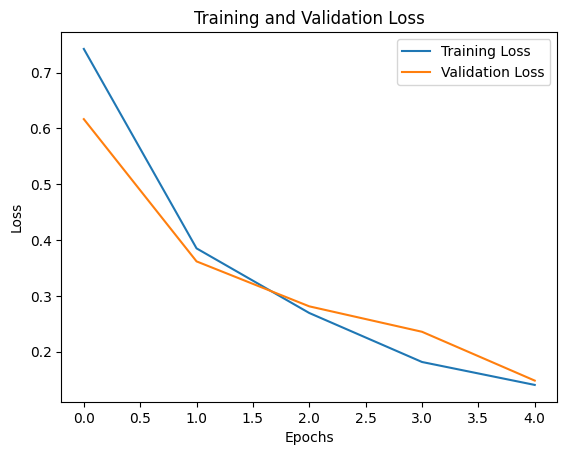

In [ ]:
# Plot training and validation loss
plt.plot(train_loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

Accuracy: 98.40%


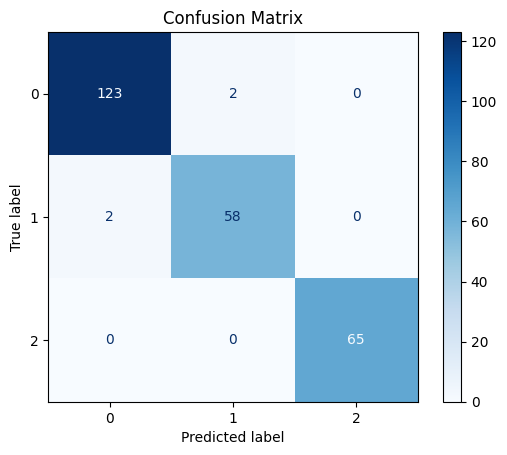

Classification Report:
              precision    recall  f1-score   support

     Class 0       0.98      0.98      0.98       125
     Class 1       0.97      0.97      0.97        60
     Class 2       1.00      1.00      1.00        65

    accuracy                           0.98       250
   macro avg       0.98      0.98      0.98       250
weighted avg       0.98      0.98      0.98       250



In [ ]:
# Evaluate Model
test_loader = DataLoader(TensorDataset(X_test_tensor, Y_test_tensor), batch_size=best_bs, shuffle=False)
evaluate_model(model, test_loader)